In [189]:
import pandas as pd
import numpy as np
import requests

# !pip install geopy
import geopy

# !pip install folium
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Get the raw data from Wikipedia
Here we are reading in all of the neighborhoods and corresponding boroughs in Berlin from a Wikipedia table. We're adding two columns for Latitude and Longitude so we can later add those using geopy.

In [191]:
url = 'https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins'
wiki = pd.read_html(url)

wiki_df = wiki[2][['Ortsteil', 'Bezirk']]

for i in range(wiki_df.shape[0]):
    wiki_df.loc[i, 'Latitude'] = np.nan
    wiki_df.loc[i, 'Longitude'] = np.nan
    
print(wiki_df.shape)
wiki_df.head()

(96, 4)


,Ortsteil,Bezirk,Latitude,Longitude
0,Mitte,Mitte,NaN,NaN
1,Moabit,Mitte,NaN,NaN
2,Hansaviertel,Mitte,NaN,NaN
3,Tiergarten,Mitte,NaN,NaN
4,Wedding,Mitte,NaN,NaN


# Include rent price data

Neuvertragsmieten auf dem Berliner Wohnungsmarkt im Jahr 2018 unterteilt nach Bezirken (in Euro pro Quadratmeter)
https://de.statista.com/statistik/daten/studie/259905/umfrage/mietpreise-in-berlin-nach-bezirken/

In [192]:
rent = {'Bezirk': ['Friedrichshain-Kreuzberg', 
                   'Mitte',
                   'Charlottenburg-Wilmersdorf',
                   'Pankow',
                   'Steglitz-Zehlendorf',
                   'Tempelhof-Schöneberg',
                   'Neukölln',
                   'Lichtenberg',
                   'Treptow-Köpenick',
                   'Reinickendorf',
                   'Spandau',
                   'Marzahn-Hellersdorf'],
        'Miete': [12.99, 12.5, 12, 10.97, 10.34, 10.26, 10.09, 9.64, 9.61, 9.11, 8.51, 7.73]
        }

rent_df = pd.DataFrame(rent, columns = ['Bezirk', 'Miete'])
rent_df.shape

(12, 2)

In [193]:
# Attach to previous dataframe

temp_df = pd.merge(wiki_df, rent_df, on = 'Bezirk')
temp_df.head()

,Ortsteil,Bezirk,Latitude,Longitude,Miete
0,Mitte,Mitte,NaN,NaN,12.5
1,Moabit,Mitte,NaN,NaN,12.5
2,Hansaviertel,Mitte,NaN,NaN,12.5
3,Tiergarten,Mitte,NaN,NaN,12.5
4,Wedding,Mitte,NaN,NaN,12.5


# Get coordinates using geopy

Now we are going to add the "center" coordinates for all 96 neighborhoods using geopy.

In [194]:
googleAPI = 'XXX' # Google API Key – to make this code run, you have to add your own.

from geopy.geocoders import GoogleV3 # Set up the geocoder
g = GoogleV3(api_key = googleAPI)

# Call the API for every single neighborhood and look up the coordinates in the format:
# 'Neighborhood', 'Borough', 'Berlin'
# Then add to the dataframe in the corresponding row.

for i in range(temp_df.shape[0]):
    current = temp_df.loc[i, 'Ortsteil'] + ', ' + temp_df.loc[i, 'Bezirk'] + ', Berlin'
    print('Getting coordinates: ' + str(i + 1) + ' of ' + str(temp_df.shape[0]), end = "\r", flush = True)
    
    loc = g.geocode(current)
    temp_df.loc[i, 'Latitude'] = loc.latitude
    temp_df.loc[i, 'Longitude'] = loc.longitude

print('Got all coordinates!')

Got all coordinates! 96 of 96


No we are making a "working version" of this dataframe so we don't have to call the API over and over again if we change something. We're also changing all column names to English.

In [195]:
berlin_df = temp_df
berlin_df.columns = ['Neighborhood', 'Borough', 'Latitude', 'Longitude', 'Rent']
print(berlin_df.to_string())

                 Neighborhood                     Borough   Latitude  Longitude   Rent
0                       Mitte                       Mitte  52.519444  13.406667  12.50
1                      Moabit                       Mitte  52.530783  13.347176  12.50
2                Hansaviertel                       Mitte  52.521312  13.343322  12.50
3                  Tiergarten                       Mitte  52.514534  13.350101  12.50
4                     Wedding                       Mitte  52.550483  13.351984  12.50
5               Gesundbrunnen                       Mitte  52.552345  13.381467  12.50
6              Friedrichshain    Friedrichshain-Kreuzberg  52.515824  13.453989  12.99
7                   Kreuzberg    Friedrichshain-Kreuzberg  52.498344  13.406579  12.99
8             Prenzlauer Berg                      Pankow  52.539179  13.424207  10.97
9                   Weißensee                      Pankow  52.553880  13.467545  10.97
10                Blankenburg              

First of all, we're going to plot all these neighborhoods to make sure that they're in the right place.

In [196]:
berlin_map = folium.Map(location = [52.520008, 13.404954], zoom_start = 10)

for lat, lng, neighborhood in zip(berlin_df['Latitude'], berlin_df['Longitude'], berlin_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.7,
        parse_html = False).add_to(berlin_map)  

berlin_map

This is looking good – we now have a dataframe that contains all Berlin neighborhoods and their center coordinates.

# Work with Foursquare
First of all, we have to define our Foursquare credentials. To make this code run, you have to enter your own.

In [197]:
CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20191201'
LIMIT = 250 # This is a problem: You can only return up to 50 venues per neighborhood!

We're using the function from the lab to get the nearby venues for all neighborhoods in the dataset.

In [211]:
def getNearbyVenues(names, latitudes, longitudes, radius = 3000):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Looking up: ' + name, sep = '', end = "\r", flush = True)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we can call the function and save the result in a new dataframe.

In [212]:
berlin_venues = getNearbyVenues(names = berlin_df['Neighborhood'],
                                   latitudes = berlin_df['Latitude'],
                                   longitudes = berlin_df['Longitude']
                                  )

In [213]:
# Remove duplicate venues and print resulting number

berlin_venues.drop_duplicates(subset = 'Venue', keep = 'first', inplace = True)
print('Foursquare found ' + str(test.shape[0]) + ' unique venues.')

# berlin_venues['Venue Category'].unique()

Foursquare found 3254 unique venues.


Now that we know how many venues we found, we are interested in two particular kinds:
1. Döner kebab places (& similar)
2. Bars & clubs

We're making a list of both venue categories and then extracting all corresponding venues to two different dataframes.

In [214]:
kebab = ['Doner Restaurant', 'Kebab Restaurant', 'Turkish Restaurant', 'Halal Restaurant', 
         'Middle Eastern Restaurant', 'Falafel Restaurant', 'Syrian Restaurant']
bars = ['Cocktail Bar', 'Bar', 'Hotel Bar', 'Dive Bar', 'Wine Bar', 'Cocktail Bar', 'Sports Bar',
        'Pub', 'Irish Pub', 'Gastropub', 'Brewery', 'Lounge', 'Beer Bar', 'Jazz Club', 'Nightclub']

kebab_venues = berlin_venues[berlin_venues['Venue Category'].isin(kebab)]
bar_venues = berlin_venues[berlin_venues['Venue Category'].isin(bars)]

print('Foursquare found ' + str(kebab_venues.shape[0]) + ' kebab places.')
print('Foursquare found ' + str(bar_venues.shape[0]) + ' bars.')

Foursquare found 74 kebab places.
Foursquare found 200 bars.


We're now going to plot all kebab places in BLUE and all bars in RED to see how they're distributed throughout Berlin.

In [215]:
berlin_gastro_map = folium.Map(location = [52.520008, 13.404954], zoom_start = 10)

# Print all of the döners
for lat, lng, name in zip(kebab_venues['Venue Latitude'], kebab_venues['Venue Longitude'], kebab_venues['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.5,
        parse_html = False).add_to(berlin_gastro_map)

# Print all of the bars
for lat, lng, name in zip(bar_venues['Venue Latitude'], bar_venues['Venue Longitude'], bar_venues['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.5,
        parse_html = False).add_to(berlin_gastro_map)  

berlin_gastro_map

We now want to know exactly how many kebab places and bars we found in each neighborhood. We're going to use One Hot Encoding for that.

In [221]:
# One hot encoding
berlin_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix = "", prefix_sep = "")

# Add neighborhood column back to dataframe
berlin_onehot['Neighborhood'] = berlin_venues['Neighborhood']

# Group by neighborhood
berlin_venues_grouped = berlin_onehot.groupby('Neighborhood').sum().reset_index()

# Sum over each category
berlin_venues_grouped['Kebab places'] = berlin_venues_grouped[kebab].sum(axis = 1, skipna = True, numeric_only = True)
berlin_venues_grouped['Bars'] = berlin_venues_grouped[bars].sum(axis = 1, skipna = True, numeric_only = True)

# Use only the columns we need
berlin_gastro_df = berlin_venues_grouped[['Neighborhood', 'Bars', 'Kebab places']]

# Calculate kebab / bar saturation
berlin_gastro_df['Kebab saturation'] = berlin_gastro_df['Kebab places'] / berlin_gastro_df['Bars'] * 100

# Filter for Neighborhoods that have more than 5 bars
berlin_gastro_df = berlin_gastro_df[berlin_gastro_df['Bars'] >= 5]

# Sort by Kebab saturation
berlin_gastro_df.sort_values(by = 'Kebab saturation', ascending = True, inplace = True)

# Add rent back in
berlin_gastro_df = pd.merge(berlin_gastro_df, berlin_df[['Neighborhood', 'Rent']], on = 'Neighborhood')
print(berlin_gastro_df.to_string())

       Neighborhood  Bars  Kebab places  Kebab saturation   Rent
0       Plänterwald     6             0          0.000000   9.61
1         Weißensee     6             0          0.000000  10.97
2         Kreuzberg    20             2         10.000000  12.99
3     Gesundbrunnen     9             1         11.111111  12.50
4          Neukölln    31             5         16.129032  10.09
5       Alt-Treptow     5             1         20.000000   9.61
6        Schöneberg     5             1         20.000000  10.26
7         Tempelhof     5             1         20.000000  10.26
8            Moabit    17             4         23.529412  12.50
9             Britz    12             3         25.000000  10.09
10  Prenzlauer Berg    12             3         25.000000  10.97
11      Heinersdorf     6             2         33.333333  10.97
12            Mitte     9             3         33.333333  12.50
13     Hansaviertel     5             2         40.000000  12.50
14          Wedding    11

/Users/yannick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Let's say we open our Kebab place – what would be the hypothetical Kebab saturation then?

In [222]:
strategy_df = berlin_gastro_df
strategy_df.columns = ['Neighborhood', 'Bars', 'Hyp. Kebab places', 'Hyp. Kebab saturation', 'Rent']

strategy_df['Hyp. Kebab places'] = strategy_df['Hyp. Kebab places'] + 1
strategy_df['Hyp. Kebab saturation'] = strategy_df['Hyp. Kebab places'] / strategy_df['Bars'] * 100
strategy_df.sort_values(by = 'Hyp. Kebab saturation', ascending = True, inplace = True)

print(strategy_df.to_string())

       Neighborhood  Bars  Hyp. Kebab places  Hyp. Kebab saturation   Rent
2         Kreuzberg    20                  3              15.000000  12.99
0       Plänterwald     6                  1              16.666667   9.61
1         Weißensee     6                  1              16.666667  10.97
4          Neukölln    31                  6              19.354839  10.09
3     Gesundbrunnen     9                  2              22.222222  12.50
8            Moabit    17                  5              29.411765  12.50
9             Britz    12                  4              33.333333  10.09
10  Prenzlauer Berg    12                  4              33.333333  10.97
5       Alt-Treptow     5                  2              40.000000   9.61
6        Schöneberg     5                  2              40.000000  10.26
7         Tempelhof     5                  2              40.000000  10.26
12            Mitte     9                  4              44.444444  12.50
11      Heinersdorf     6

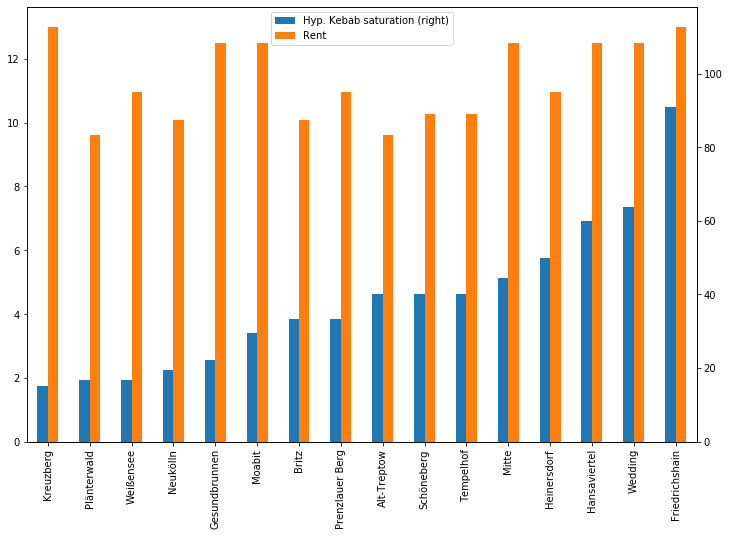

In [224]:
# Visualize in a bar chart

plot_df = strategy_df[['Neighborhood', 'Hyp. Kebab saturation', 'Rent']]

import matplotlib.pyplot as plt
 
x_pos = np.arange(len(strategy_df['Neighborhood']))
 
plot_df.plot(kind = 'bar' , secondary_y =  'Hyp. Kebab saturation', figsize = (12, 8))
plt.xticks(x_pos, strategy_df['Neighborhood'])
plt.margins(0.3)
plt.show()

In [233]:
strategy_bars = bar_venues[berlin_venues['Neighborhood'] == 'Kreuzberg']
strategy_kebab = kebab_venues[berlin_venues['Neighborhood'] == 'Kreuzberg']

yourplace_lat = strategy_bars['Venue Latitude'].mean()
yourplace_long = strategy_bars['Venue Longitude'].mean()

/Users/yannick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/yannick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [235]:
strategy_map = folium.Map(location = [52.483803, 13.430718], zoom_start = 13)

# Print all of the döners
for lat, lng, name in zip(strategy_kebab['Venue Latitude'], strategy_kebab['Venue Longitude'], strategy_kebab['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.5,
        parse_html = False).add_to(strategy_map)

# Print all of the bars
for lat, lng, name in zip(strategy_bars['Venue Latitude'], strategy_bars['Venue Longitude'], strategy_bars['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.5,
        parse_html = False).add_to(strategy_map)
    
# Print your own kebab location
folium.CircleMarker(
        [yourplace_lat, yourplace_long],
        radius = 10,
        popup = folium.Popup('YOUR LOCATION', parse_html = True),
        color = 'yellow',
        fill = True,
        fill_color = 'yellow',
        fill_opacity = 0.8,
        parse_html = False).add_to(strategy_map)

strategy_map